# Deep Q Learning with Count

From the Deep Learning notebook, which adapted the Q learning algorithm to a Deep Q Learning approach, can I now incorporate card count?

In [167]:
import torch
import torch.nn as nn
import onnx
torch.manual_seed(0)

In [168]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
import numpy as np

# Custom Modules.
from src.modules.game import Game
from src.modules.cards import Card, SuitEnum

from src.deep_learning.modules import Net, Trainer

from src.deep_learning.utils.viz import plot_mesh, show_action_table, generate_grid
from src.deep_learning.utils.replay_buffer import generate_state_action_pairs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Evaluate card count distributions through game play

Distributions are mostly normal. However, they are more heavily centered towards 0, which makes sense given that card count resets upon shuffling. It would be more drastic if we didn't have a cut card (ratio_penetrate variable), as no matter what the count gets to during gameplay, the count is guaranteed to approach 0 at the end of the deck.

For this simple approach, I use random policy selection (of valid actions), and only assess card count once the initial deal is performed.

We can also observe the true card count. This is much more heavily skewed towards zero.

In [169]:
rules = {
    "dealer_hit_soft17": False,
    "push_dealer22": False,
    "double_after_split": True,
    "hit_after_split_aces": False,
    "reduced_blackjack_payout": False,
    "allow_surrender": True,
    "split_any_ten": True,
}

game_hyperparams = {
    "shrink_deck": True,
    "n_decks": 6,
    "ratio_penetrate": 2/3,
    "rules": rules
}

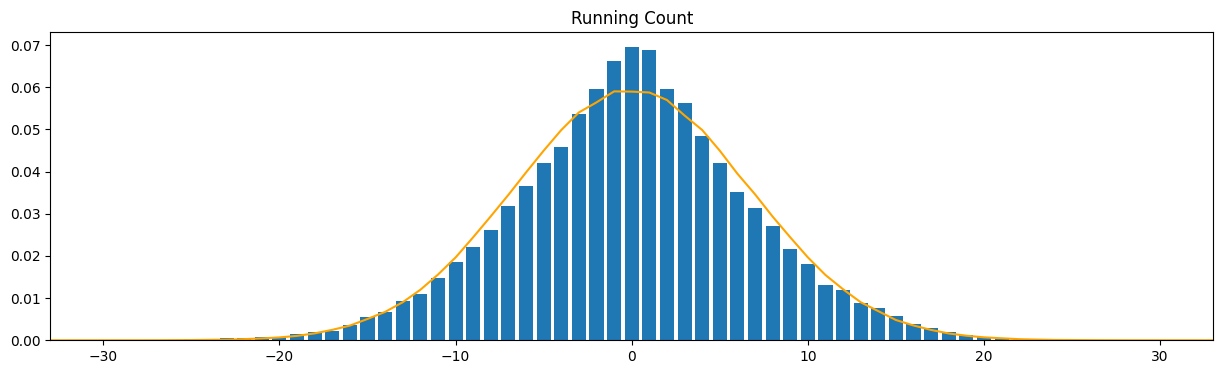

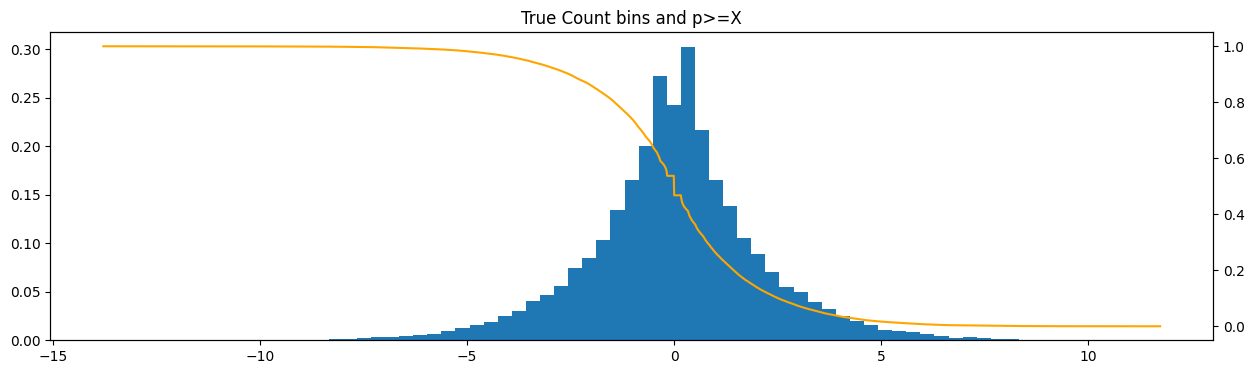

In [4]:
blackjack = Game(**game_hyperparams)
counts = []
true_counts = []

player_ind = 0

for _ in range(50_000) :
    
    blackjack.init_round(wagers=[1])
    blackjack.deal_init()
    player = blackjack.players[player_ind] # only 1 player, so i'll just extract that specific player module.
    house_show = blackjack.get_house_show()

    # I'll extract counts after the initial deal.
    counts.append(blackjack.count)
    true_counts.append(blackjack.true_count)

    while not player.is_done() :

        player_show,useable_ace = player.get_value()

        policy = player.get_valid_moves()
        policy = [p for p in policy if p!='insurance']

        move = np.random.choice(policy)

        blackjack.step_player(player_ind, move)

    blackjack.step_house(only_reveal_card=True)
    while not blackjack.house_done():
        blackjack.step_house()
    
plt.figure(figsize=(15,4))
plt.title("Running Count")
inds = np.argsort(pd.Series(counts).value_counts(normalize=True).index.to_list())
plt.bar(
    pd.Series(counts).value_counts(normalize=True).index[inds],
    pd.Series(counts).value_counts(normalize=True).values[inds]
)
samples = np.random.normal(0,np.array(counts).std(), 1_000_000)
minmax = max(abs(min(counts)), max(counts))
a, b = np.histogram(samples, np.arange(-minmax-1.5, minmax+1.5), density=True)
plt.plot([b[i-1:i+1].mean() for i in range(1,b.shape[0])], a, color="orange")
plt.xlim(-minmax, minmax)
plt.show()

ranges = np.arange(min(true_counts), max(true_counts)+0.01, 0.01)
y = []
for r in ranges:
    y.append(np.where(np.array(true_counts) >= r)[0].shape[0] / len(true_counts))

fig, ax1 = plt.subplots(figsize=(15,4))
ax1.set_title("True Count bins and p>=X")
ax2 = ax1.twinx()
ax1.hist(true_counts, bins=75, density=True)
ax2.plot(ranges, y, color="orange")
plt.show()


## Deep Q Learning Training Process

I'll follow the same approach as I did in the `Deep_Learning` notebook, by doing implicit action masking. I found that this led to better performance in practice, and really put an emphasis on the network learning which moves were feasible and which weren't.

**To handle Card Count, I take the following approach:**

Card count is ONLY computed after the initial deal, by default. If desired, the card count can be updated after each player move. However, I figure that once the count is set upon initial deal, the player's style of play is set for the round.\
The Game module is smart in that it accounts for the house's hidden card if the house had not played yet. In essensce, we never have a PERFECT idea of the card count, since there's always 1 card in play that players don't have access to. Once the house plays, the card count updates accordingly when `get_count()` is called

Since the `update_replay_buffer()` function can stop gameplay early upon invalid action selection, it was necessary to implement a `get_count()` method in the gameplay that is computed during each call, rather than continuously updating a class parameter.



In [211]:
def get_decay_factor(max_val, min_val, n):
    return np.log(max_val / min_val) / n

def get_current_decay_value(max_val, decay_factor, n):
    return max_val * np.exp(-decay_factor * n)

REPLAY_SIZE = 10_000
MIN_REPLAY_SIZE = 1_000 # this won't be hit exactly due to splitting during gameplay.
GAMMA = 0.95

TARGET_UPDATE_FREQ = 5_000
N_EPOCHS = 1_500_000
EVAL_EVERY = 10_000
BATCH_SIZE = 16

LR = 0.001
LR_MIN = 0.0001
EPS_MIN = .1

EPS_DECAY = get_decay_factor(1, EPS_MIN, N_EPOCHS)
LR_DECAY = get_decay_factor(LR, LR_MIN, N_EPOCHS)

USE_COUNT = True

method = "softmax" # can be epsilon or softmax.

input_dim = 3 + 0 + int(USE_COUNT)
hidden_layers = [50, 25]

In [212]:
# Forcefully inject infrequently visited player card combos during training.

cards_force = []
for c in [2,3,4,5,6,7,8,9,10,"A"]:
    cards_force.append([Card(suit=SuitEnum.clubs, card=c) for _ in range(2)])
for c in [2,3,4,5,6,7,8,9,10]:
    cards_force.append([Card(suit=SuitEnum.clubs, card="A"), Card(suit=SuitEnum.clubs, card=c)])

In [213]:
online_net = Net(input_dim, hidden_layers=hidden_layers)
target_net = Net(input_dim, hidden_layers=hidden_layers)

trainer = Trainer(
    online_net=online_net,
    target_net=target_net,
    replay_size=REPLAY_SIZE,
    include_count=USE_COUNT,
)

# loss_fct = nn.SmoothL1Loss()
loss_fct = nn.MSELoss()
optimizer = torch.optim.Adam(online_net.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=(1 - LR_DECAY))

trainer.copy_online_to_target()

In [214]:
blackjack = Game(**game_hyperparams)

mean_rewards = []
training_loss = []

# first randomly generate our replay_buffer.
# I want to isolate this so it doesn't eat away at the epochs
# used towards training.
replay_sufficient = False
while not replay_sufficient:
    trainer.update_buffer(blackjack=blackjack, method="random")
    replay_sufficient = len(trainer.replay_buffer.memory) >= MIN_REPLAY_SIZE


for step in range(N_EPOCHS):
    print(f"Round {step}", end="\r")

    eps = get_current_decay_value(1, EPS_DECAY, step)

    m = method
    if method == "epsilon":
        m = "random" if np.random.sample() < eps else "argmax"

    # forceful injection of infrequent player cards into the initial deal.
    forced_cards = []
    if not step % 10:
        forced_cards_i = np.random.choice(len(cards_force))
        forced_cards = cards_force[forced_cards_i]

    trainer.update_buffer(blackjack=blackjack, method=m, force_cards=forced_cards)

    loss_epoch = trainer.train_epoch(
        batch_size=BATCH_SIZE,
        gamma=GAMMA,
        loss_fct=loss_fct,
        optimizer=optimizer,
        scheduler=scheduler
    )
    training_loss.append(loss_epoch)

    if not (step % TARGET_UPDATE_FREQ):
        trainer.copy_online_to_target()

    if (not step % EVAL_EVERY) or (step + 1 == N_EPOCHS):
        mean_reward = await trainer.eval(
            n_games=100,
            n_rounds=50,
            wagers=[1],
            game_hyperparams=game_hyperparams
        )
        mean_rewards.append(mean_reward)
        print(f"step {step}\
 ---- mean reward per round {mean_reward:.4f}\
 ---- epoch training loss {loss_epoch:.4f}\
 ---- eps {eps:.4f}\
 ---- lr {optimizer.param_groups[0]['lr']:.4f}")

network = Net(input_dim, hidden_layers=hidden_layers)

network.load_state_dict(deepcopy(trainer.online_net.state_dict()))
network.eval()

step 0 ---- mean reward per round -0.6472 ---- epoch training loss 1.4437 ---- eps 1.0000 ---- lr 0.0010
step 10000 ---- mean reward per round -0.1073 ---- epoch training loss 0.9061 ---- eps 0.9848 ---- lr 0.0010
step 20000 ---- mean reward per round -0.0428 ---- epoch training loss 1.1008 ---- eps 0.9698 ---- lr 0.0010
step 30000 ---- mean reward per round -0.0115 ---- epoch training loss 0.7273 ---- eps 0.9550 ---- lr 0.0010
step 40000 ---- mean reward per round -0.0326 ---- epoch training loss 0.9250 ---- eps 0.9404 ---- lr 0.0009
step 50000 ---- mean reward per round -0.0200 ---- epoch training loss 0.5867 ---- eps 0.9261 ---- lr 0.0009
step 60000 ---- mean reward per round -0.0291 ---- epoch training loss 0.3988 ---- eps 0.9120 ---- lr 0.0009
step 70000 ---- mean reward per round -0.0366 ---- epoch training loss 0.9213 ---- eps 0.8981 ---- lr 0.0009
step 80000 ---- mean reward per round -0.0283 ---- epoch training loss 0.5346 ---- eps 0.8844 ---- lr 0.0009
step 90000 ---- mean re

Net(
  (fc_input): Linear(in_features=4, out_features=50, bias=True)
  (fc_hidden): ModuleList(
    (0): Linear(in_features=50, out_features=25, bias=True)
  )
  (fc_output): Linear(in_features=25, out_features=5, bias=True)
)

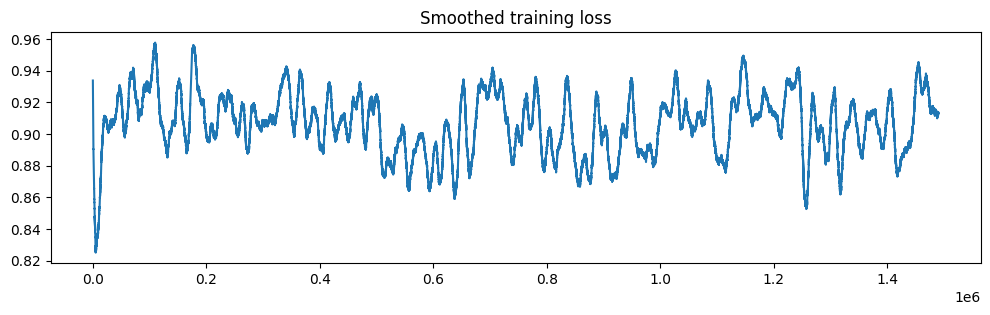

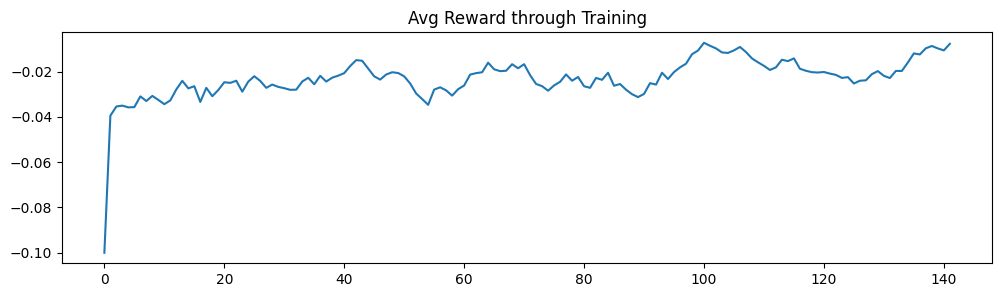

In [215]:
plt.figure(figsize=(12,3))
plt.plot(np.convolve(training_loss, np.ones(10000)/10000, mode="valid"))
plt.title("Smoothed training loss")
# plt.vlines(range(len(training_loss))[::1000], ymin=.25, ymax=.55)
plt.show()

plt.figure(figsize=(12,3))
plt.plot(np.convolve(mean_rewards, np.ones(10)/10, mode="valid"))
plt.title("Avg Reward through Training")
plt.show()

## Saving / Loading the model

I also export an onnx model, which is compatible with client-side webGPU usage.

In [216]:
torch.save(network.state_dict(), "./models/deep_q_count.pt")

torch.onnx.export(
    network,
    torch.tensor([[5,11,-1, 1.0]], dtype=torch.float32),
    "./models/deep_q_count.onnx"
)

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [217]:
model = onnx.load("./models/deep_q_count.onnx")

onnx.checker.check_model(model)

In [218]:
network =  Net(input_dim, hidden_layers=hidden_layers)
network.load_state_dict(torch.load("./models/deep_q_count.pt"))
network.eval()

Net(
  (fc_input): Linear(in_features=4, out_features=50, bias=True)
  (fc_hidden): ModuleList(
    (0): Linear(in_features=50, out_features=25, bias=True)
  )
  (fc_output): Linear(in_features=25, out_features=5, bias=True)
)

## Evaluation

It's important to note that we are never changing our wager. Playing M games of N rounds each will mean we're going to approach the card count of 0 with high likelihood. Based off the plots above, the running count is roughly normally distributed, and the true count is more concentrated towards zero with shorter tails. I don't expect our performance to improve, on average, compared with the deep network without card count.

To really uncover what added benefit we get from including true count into our model, we'll need to break down performance a bit further.

#### Evaluation of Value Function

Fixing the true count to be a certain value, what does our value function look like? (It should look nearly identical to the value function in the `Deep_Learning` notebook). We can explore the value of being in a certain state, and see how it changes as the true count changes.

It seems intuitive that while having a 10 or 11 is typically a high-value spot to be in, if the true count is very negative, these become drastically lower-value states to be in. We see these occur when observing the mesh plots below for the -5, 0, +5 true count observations

In [219]:
from src.deep_learning.utils.viz import gen_all_states

In [220]:
def get_masked_output_space(
        model: Net, data, action_space):

    data_t = torch.tensor(data, dtype=torch.float32)
    actions = [action_space]*len(data)
    q_masked, _, _ = model.act(data_t, method="argmax", avail_actions=actions)

    return q_masked

def fill_value_grid(model: Net, states, hand_type: str):

    if hand_type == "hard":
        fill = np.full((16, 10), np.nan)
        policy = ["hit", "stay", "double", "surrender"]
    if hand_type == "soft":
        fill = np.full((8, 10), np.nan)
        policy = ["hit", "stay", "double", "surrender"]
    if hand_type == "split":
        fill = np.full((10, 10), np.nan)
        policy = ["hit", "stay", "double", "split", "surrender"]

    q_masked = get_masked_output_space(
        model=model,
        data=states,
        action_space=policy
    )

    for i, q in enumerate(q_masked):
        player, house, useable_ace, _ = states[i]
        can_split = (not player % 2) and\
            ((useable_ace < 0) or (player == 12)) and\
            ("split" in policy)
        if can_split:
            r = 11 if (useable_ace > 0) else int(player / 2)
            player_ind = 11 - r
        else:
            player_ind = 20 - player
        fill[player_ind, house - 2] = torch.max(q)

    return fill

In [221]:
all_states = {}
states = gen_all_states()
for c in range(-5,6,1):
    all_states[c] = {}
    all_states[c]["states"] = [tuple(list(state) + [c]) for state in states]

In [222]:

for k,v in all_states.items():

    hard_states = list(filter(lambda x : (x[2] < 0) and (x[0] > 4), all_states[k]["states"]))
    soft_states = list(
        filter(
            lambda x : (x[2] > 0) and (
                not ((not x[0] % 2) and ((x[2] < 0) or (x[0] == 12)))
            ),
            all_states[k]["states"]
        ))
    split_states = list(
        filter(
            lambda x : (not x[0] % 2) and ((x[2] < 0) or (x[0] == 12)),
            all_states[k]["states"]
        ))
    
    hard_totals = fill_value_grid(
        model=network,
        states=hard_states,
        hand_type="hard"
    )
    soft_totals = fill_value_grid(
        model=network,
        states=soft_states,
        hand_type="soft"
    )
    split_totals = fill_value_grid(
        model=network,
        states=split_states,
        hand_type="split"
    )

    v["hard"] = hard_totals
    v["soft"] = soft_totals
    v["split"] = split_totals

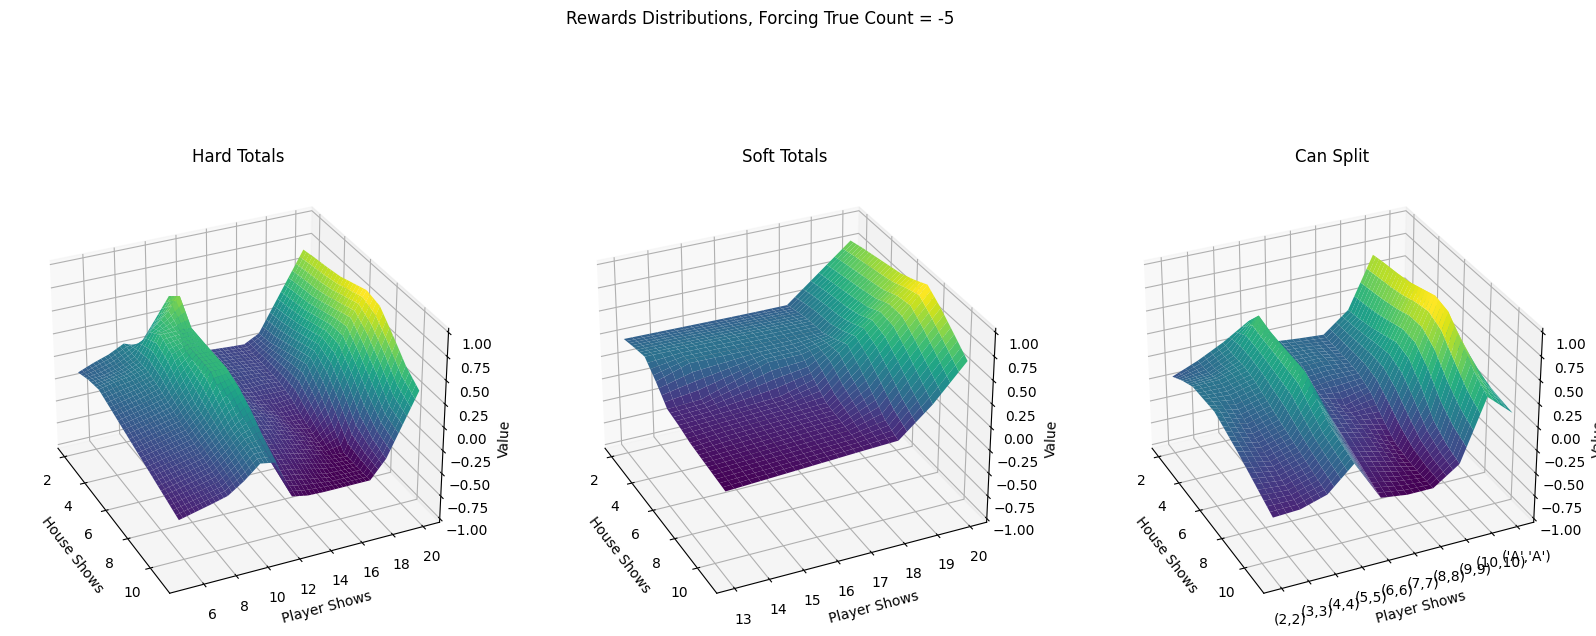

In [223]:
fig = plt.figure(figsize=(20,8))

count = -5

fig.suptitle(f"Rewards Distributions, Forcing True Count = {count}")
ax = fig.add_subplot(131, projection="3d")
ax.set_title("Hard Totals")

plot_mesh(
    axis=ax,
    data=all_states[count]["hard"],
    ranges=[range(2,12),range(20,4,-1)],
    interpolate=4,
    ticks=None,
    zlims=[-1, 1],
)

ax = fig.add_subplot(132, projection="3d")
ax.set_title("Soft Totals")

plot_mesh(
    axis=ax,
    data=all_states[count]["soft"],
    ranges=[range(2,12),range(20,12,-1)],
    interpolate=4,
    ticks=None,
    zlims=[-1, 1],
)

ax = fig.add_subplot(133, projection="3d")
ax.set_title("Can Split")

ticks = [f"({p},{p})" if p < 11 else "('A','A')" for p in range(2,12)]
plot_mesh(
    axis=ax,
    data=all_states[count]["split"],
    ranges=[range(2,12),range(11,1,-1)],
    interpolate=4,
    ticks=ticks,
    zlims=[-1, 1],
)

plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

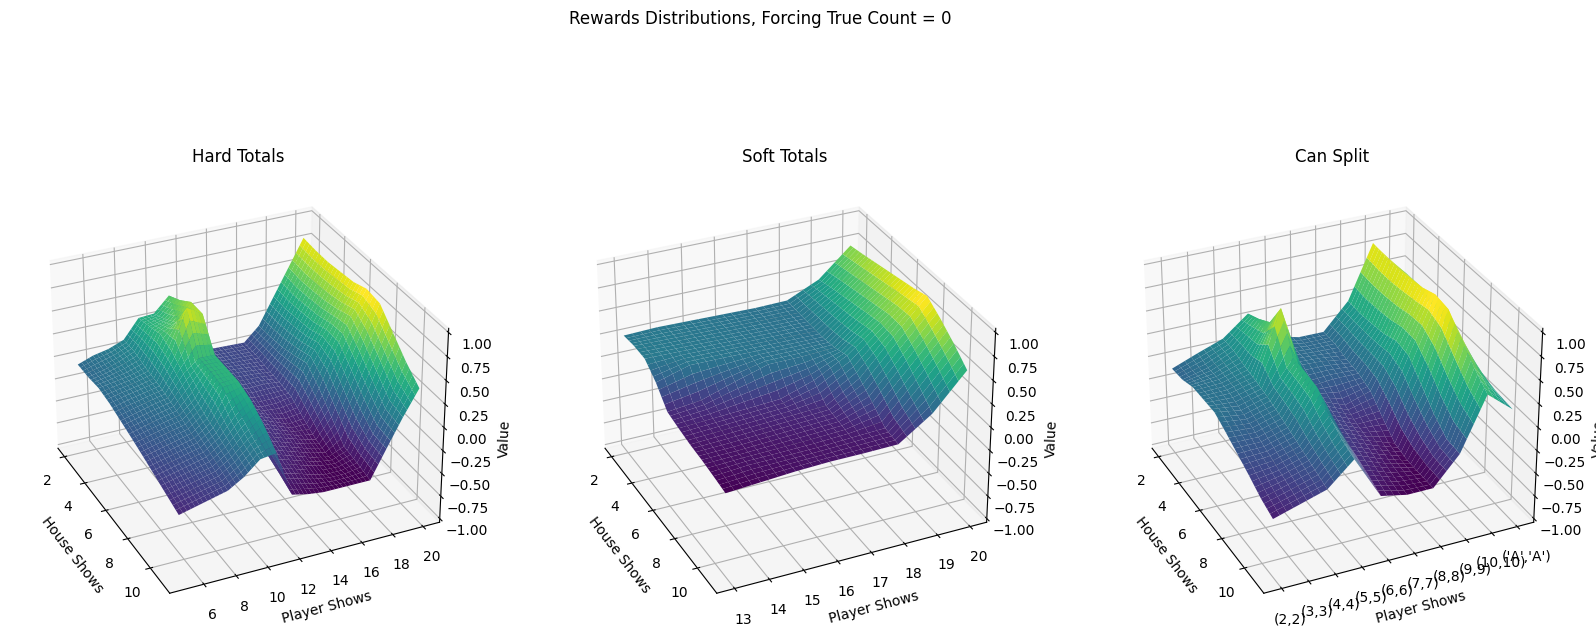

In [224]:
fig = plt.figure(figsize=(20,8))

count = 0

fig.suptitle(f"Rewards Distributions, Forcing True Count = {count}")
ax = fig.add_subplot(131, projection="3d")
ax.set_title("Hard Totals")

plot_mesh(
    axis=ax,
    data=all_states[count]["hard"],
    ranges=[range(2,12),range(20,4,-1)],
    interpolate=4,
    ticks=None,
    zlims=[-1, 1],
)

ax = fig.add_subplot(132, projection="3d")
ax.set_title("Soft Totals")

plot_mesh(
    axis=ax,
    data=all_states[count]["soft"],
    ranges=[range(2,12),range(20,12,-1)],
    interpolate=4,
    ticks=None,
    zlims=[-1, 1],
)

ax = fig.add_subplot(133, projection="3d")
ax.set_title("Can Split")

ticks = [f"({p},{p})" if p < 11 else "('A','A')" for p in range(2,12)]
plot_mesh(
    axis=ax,
    data=all_states[count]["split"],
    ranges=[range(2,12),range(11,1,-1)],
    interpolate=4,
    ticks=ticks,
    zlims=[-1, 1],
)

plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

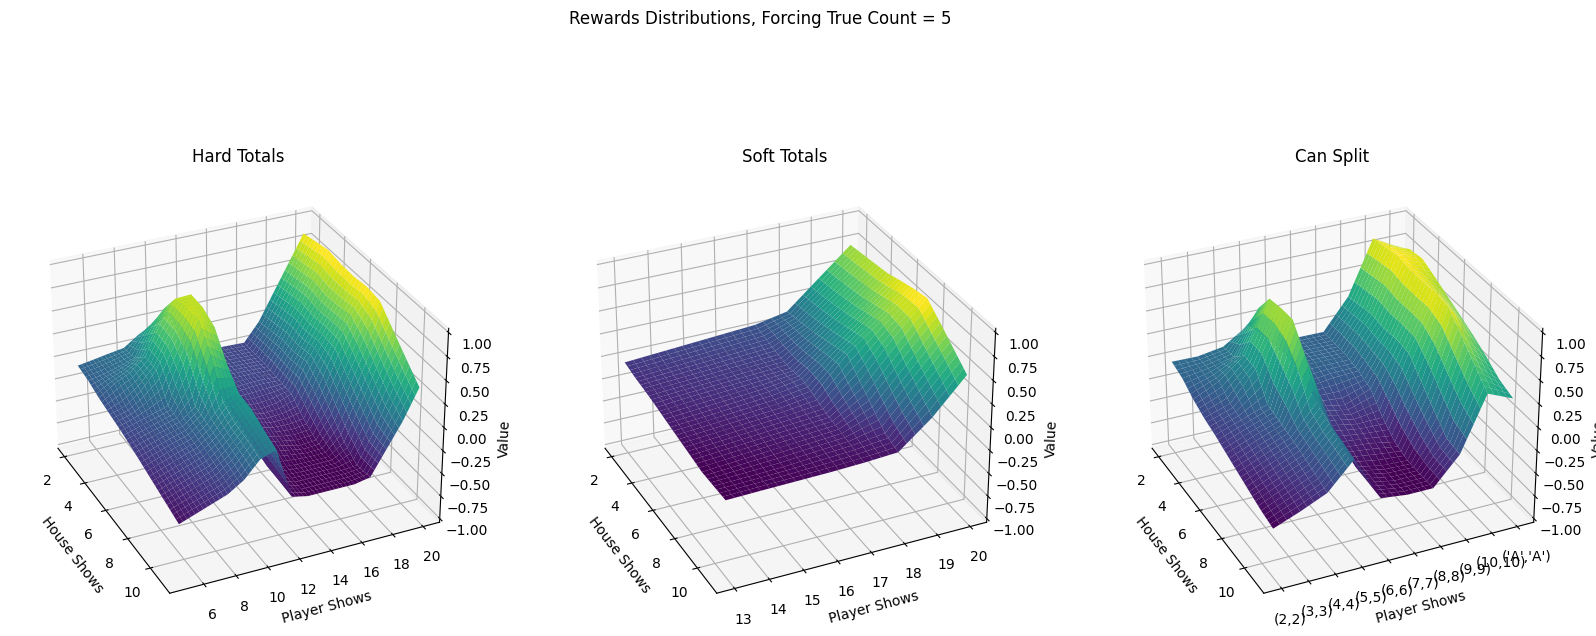

In [225]:
fig = plt.figure(figsize=(20,8))

count = 5

fig.suptitle(f"Rewards Distributions, Forcing True Count = {count}")
ax = fig.add_subplot(131, projection="3d")
ax.set_title("Hard Totals")

plot_mesh(
    axis=ax,
    data=all_states[count]["hard"],
    ranges=[range(2,12),range(20,4,-1)],
    interpolate=4,
    ticks=None,
    zlims=[-1, 1],
)

ax = fig.add_subplot(132, projection="3d")
ax.set_title("Soft Totals")

plot_mesh(
    axis=ax,
    data=all_states[count]["soft"],
    ranges=[range(2,12),range(20,12,-1)],
    interpolate=4,
    ticks=None,
    zlims=[-1, 1],
)

ax = fig.add_subplot(133, projection="3d")
ax.set_title("Can Split")

ticks = [f"({p},{p})" if p < 11 else "('A','A')" for p in range(2,12)]
plot_mesh(
    axis=ax,
    data=all_states[count]["split"],
    ranges=[range(2,12),range(11,1,-1)],
    interpolate=4,
    ticks=ticks,
    zlims=[-1, 1],
)

plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

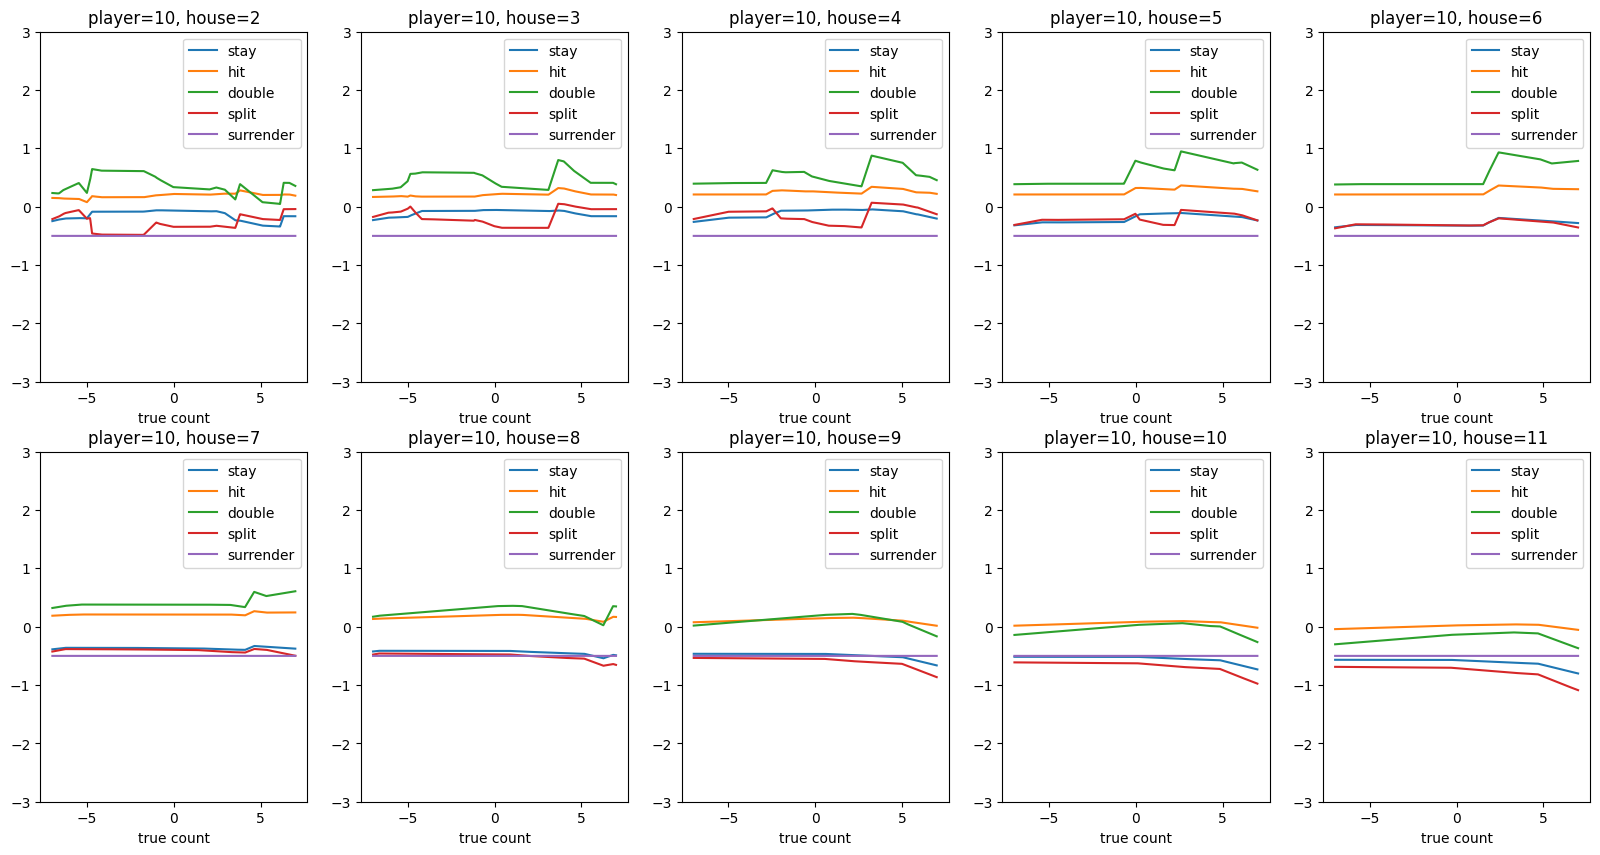

In [228]:
fig = plt.figure(figsize=(20,10))

nrows = 2
ncols = 5

player = 10
useable_ace = -1

count_range = np.arange(-7, 7.01, 0.01)

for h in range(10):
    obs = []

    ax = fig.add_subplot(nrows, ncols, h + 1)
    ax.set_title(f"player={player}, house={h + 2}")

    for j in count_range:
        obs.append((player, h + 2, useable_ace, j))

    with torch.no_grad():
        q = network(torch.tensor(obs, dtype=torch.float32))
    for i in range(5):
        ax.plot(count_range, q[:,i], label=network.moves[i])
    ax.legend()
    ax.set_xlabel("true count")
    ax.set_ylim(-3,3)
plt.show()

#### True Count Impact on Rewards

I can partition the earned rewards, following the optimal policy, by true count at the time of round start, and assess how this impacts outcome. While it's clear how our value function changes as we compare the extreme true count differences, it'd be interesting to see how this actually translates to winnings.

In [153]:
%load_ext autoreload
%autoreload 2

from src.deep_learning.utils.runner import play_games_gather_count

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
blackjack = Game(**game_hyperparams)

res = await play_games_gather_count(
    model=network,
    n_games=1_000,
    n_rounds=100,
    wagers=[1],
    game_hyperparams=game_hyperparams
)

In [162]:
bins = np.arange(-5, 5.1, .1)
inds = np.digitize(np.array(res)[:,0], bins)

In [163]:
x = []
y = []
bj = []

for i in range(bins.shape[0]):
    x.append(bins[i])
    inds_find = np.where(inds == i)[0]
    if len(inds_find):
        y.append(np.array(res)[:,2][inds_find].mean())
        bj.append(np.array(res)[:,1][inds_find].mean())
    else:
        y.append(np.nan)
        bj.append(np.nan)

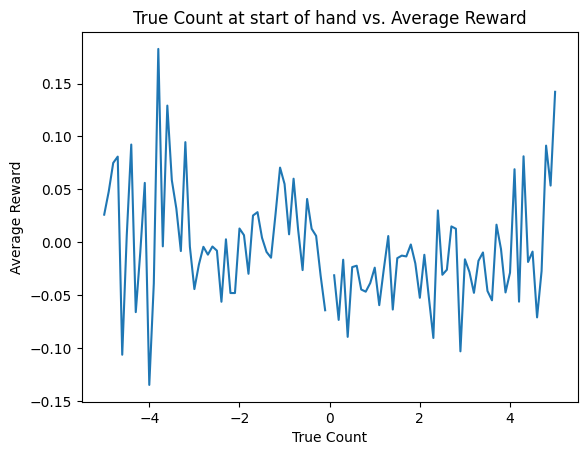

In [164]:
plt.plot(x,y)
plt.title("True Count at start of hand vs. Average Reward")
plt.xlabel("True Count")
plt.ylabel("Average Reward")
plt.show()

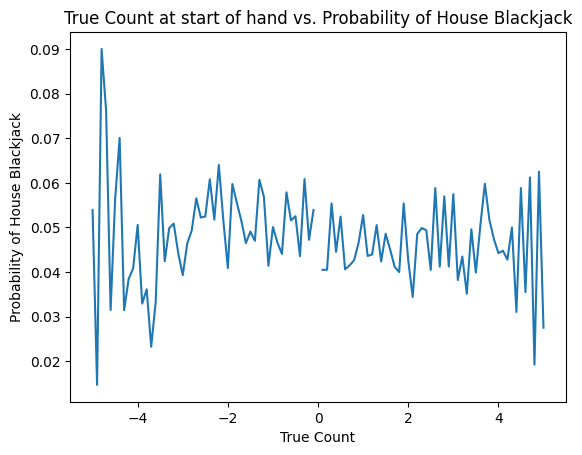

In [165]:
plt.plot(x,bj)
plt.title("True Count at start of hand vs. Probability of House Blackjack")
plt.xlabel("True Count")
plt.ylabel("Probability of House Blackjack")
plt.show()